In [0]:
!pip install pytorch_transformers flair seqeval

     |████████████████████████████████| 184kB 9.0MB/s 
     |████████████████████████████████| 143kB 17.3MB/s 
     |████████████████████████████████| 1.0MB 20.0MB/s 
     |████████████████████████████████| 890kB 30.5MB/s 
     |████████████████████████████████| 798kB 53.3MB/s 
     |████████████████████████████████| 645kB 49.7MB/s 
     |████████████████████████████████| 983kB 56.1MB/s 
     |████████████████████████████████| 256kB 48.7MB/s 
     |████████████████████████████████| 3.8MB 52.0MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=e1deeac9a2ea8be66b571efaaa628d0d2a1ecc75f85f4e29ba662e24c73469c2
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=40fbeb82979b99157739ef171ae52b11ef694523d7277dad9f20cbc8ed739dd7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a501

In [0]:
import os
import csv
import sys
import torch
import logging
from flair.datasets import ColumnCorpus
from keras.preprocessing.text import text_to_word_sequence

Using TensorFlow backend.


In [0]:
from bert_sequence_tagger.model_trainer_bert import ModelTrainerBert
from bert_sequence_tagger import SequenceTaggerBert, BertForTokenClassificationCustom
from bert_sequence_tagger.bert_utils import get_model_parameters, prepare_flair_corpus
from bert_sequence_tagger.metrics import f1_entity_level, f1_token_level, f1_per_token, f1_per_token_plot
from bert_sequence_tagger.plot_classification_report import plot_classification_report
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger('sequence_tagger_bert')

In [0]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device('cuda')
n_gpu = torch.cuda.device_count()

for i in range(n_gpu):
    print(torch.cuda.get_device_name(i))

seq_tagger = SequenceTaggerBert.load_serialized('/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T047005007016', BertForTokenClassificationCustom)

locs = ['/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T005','/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T007','/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T016','/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T047']
models = [SequenceTaggerBert.load_serialized(x , BertForTokenClassificationCustom) for x in locs]

Tesla P4
INFO:pytorch_transformers.modeling_utils:loading configuration file /content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T047005007016/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 6,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.modeling_utils:loading weights file /content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T047005007016/pytorch_model.bin
INFO:pytorch_transformers.modeling_utils:loading configuration file /content/drive/My D

In [0]:
class BERT:
  def return_tags_MMT(self,para):
    para_split = para.split('.')
    para_split = [text_to_word_sequence(x) for x in para_split]
    tags,prob = seq_tagger.predict(para_split)
    op_file_1 = open("data/para_tags_MMT.csv",'w')
    writer_1 = csv.writer(op_file_1)
    _ = ['Words','Tags']
    writer_1.writerow(_)
    for i,t in zip(para_split,tags):
      for x,y in zip(i,t):
        row = [x,y]
        writer_1.writerow(row)
      writer_1.writerow([''])
    '''
    for each row to have a full sentence(word per cell in a row) and tags(wrt word) use the code below
    for i,t in zip(para_split,final_tags):
      writer.writerow(i)
      writer.writerow(t)
      writer.writerow([''])
    '''

  def return_tags_MPT(self,para):
    final_tags = []
    for mod in models:
        para_split = para.split('. ')
        para_split = [text_to_word_sequence(x) for x in para_split]
        tags,prob = mod.predict(para_split)
        if not final_tags:
          final_tags = tags
        for _ in range(len(final_tags)):
          for x in range(len(final_tags[_])):
            if final_tags[_][x] == 'O':
              final_tags[_][x] = tags[_][x] 
            elif tags[_][x] != 'O' and final_tags[_][x] != tags[_][x]:
              final_tags[_][x] += ', ' + tags[_][x]
    op_file = open("data/para_tags_MPT.csv",'w')
    writer = csv.writer(op_file)
    _ = ['Words','Tags']
    writer.writerow(_)
    for i,t in zip(para_split,final_tags):
      for x,y in zip(i,t):
        row = [x,y]
        writer.writerow(row)
      writer.writerow([''])
    '''
    for each row to have a full sentence(word per cell in a row) and tags(wrt word) use the code below
    for i,t in zip(para_split,final_tags):
      writer.writerow(i)
      writer.writerow(t)
      writer.writerow([''])
    '''

  def give_metrics(self):
    test_file = input("Test-File: ")
    data_folder = 'data'
    corpus = ColumnCorpus(data_folder, {0 : 'idx', 2 : 'text', 3 : 'ner' },
                        train_file=test_file,
                        test_file=test_file,
                        dev_file=test_file)
    test_dataset = prepare_flair_corpus(corpus.test)

    _, __, test_metrics = seq_tagger.predict(test_dataset, evaluate=True, 
                                            metrics=[f1_entity_level, f1_token_level, f1_per_token, f1_per_token_plot])
    logger.info(f'Entity-level f1: {test_metrics[1]}')
    logger.info(f'Token-level f1: {test_metrics[2]}') 
    logger.info(f'per-Token-level f1: \n {test_metrics[3]}')

    ##Confusion matrix style
    plot_classification_report(test_metrics[3])

    ##Classification report BAR graph##
    results = test_metrics[4][0]
    key = ['precision','recall','f1-score','support']
    indices = np.arange(len(results))
    labels = [y for y in results.keys()]
    results_t = [[x[i] for x in results.values()] for i in key]
    precision,recall,f1_score,support = results_t
    plt.title("Metrics")
    plt.barh(indices, precision, .2, label="precision", color='navy',)
    plt.barh(indices + .3, f1_score, .2, label="f1_score",
             color='c')
    plt.barh(indices + .6, recall, .2, label="recall", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, labels):
        plt.text(-.1, i, c,)

    for i, v in enumerate(precision):
        plt.text(v , i - 0.1, str(v)[0:6], color='navy')

    for i, v in enumerate(f1_score):
        plt.text(v , i + 0.2, str(v)[0:6], color='c')

    for i, v in enumerate(recall):
        plt.text(v , i + 0.5, str(v)[0:6], color='darkorange')

    #plt.show()
    fig = plt.gcf()
    #20,100
    fig.set_size_inches(20,20, forward=True)
    fig.savefig('class_rep_bar_graph.png',format='png', bbox_inches='tight')

    plt.cla()
    plt.clf()
    plt.close()

    ##Accuracy graph##
    objects = test_metrics[4][2]
    y_pos = np.arange(len(objects))
    performance = test_metrics[4][1]

    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Accuracy')
    plt.title('Accuracy per token/class')

    for i, v in enumerate(performance):
      plt.text(v , i - 0.1, str(v)[0:4], color='navy')

    fig = plt.gcf()
    fig.set_size_inches(7,5, forward=True)
    fig.savefig('acc_bar_graph.png',format='png', bbox_inches='tight', dpi=300)
    
  def __init__(self):
    run = 1
    print('Please put the test.txt file generated for the BERT model in the data folder')
    while run != 4:
      run = int(input("\n--------------------\nChoose: \n1)Tags_MMT \n2)Tags_MPT \n3)Metrics \n4)Exit \nInput option num : "))
      print("--------------------\n")
      if run == 1:
        print("Enter text: ")
        para = input()
        self.return_tags_MMT(para)
      elif run == 2:
        print("Enter text: ")
        para = input()
        self.return_tags_MPT(para)
      elif run == 3:
        self.give_metrics()
      
      

In [0]:
run = BERT()

Please put the test.txt file generated for the BERT model in the data folder

--------------------
Choose: 
1)Tags_MMT 
2)Tags_MPT 
3)Metrics 
4)Exit 
Input option num : 1
--------------------

Enter text: 
streptococcus mitis

--------------------
Choose: 
1)Tags_MMT 
2)Tags_MPT 
3)Metrics 
4)Exit 
Input option num : 2
--------------------

Enter text: 
streptococcus mitis

--------------------
Choose: 
1)Tags_MMT 
2)Tags_MPT 
3)Metrics 
4)Exit 
Input option num : 4
--------------------



In [0]:
import csv
check_data = open("data/labelled_data_alltags.txt")

csv_file = open("data/res_check.xlsx",'w')
writer = csv.writer(csv_file)

No_of_mistakes = 0
No_of_lines = 0

switch = True
words=[]
tags=[]
for line in check_data.readlines():
  if len(line)==0:
    coninue
  elif switch:
    words = line.split()
    switch = not switch
  else:
    tags = line.split()
    switch = not switch
    res , prob = seq_tagger.predict([words])
    res = res[0]
    No_of_lines += 1
    if No_of_lines % 100 == 0:
      print("Line = ",No_of_lines)
    if res != tags:
      writer.writerow(words)
      writer.writerow(tags)
      writer.writerow(res)
      writer.writerow([''])
      No_of_mistakes +=1
      if No_of_mistakes % 10 == 0:
        print('Mistakes = ',No_of_mistakes)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
TESTING

In [0]:
import pandas as pd
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device('cuda')
n_gpu = torch.cuda.device_count()

for i in range(n_gpu):
    print(torch.cuda.get_device_name(i))

#seq_tagger = SequenceTaggerBert.load_serialized('/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T047005007016', BertForTokenClassificationCustom)
locs = ['/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T047005007016','/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T005','/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T007','/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T016','/content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T047']
models = [SequenceTaggerBert.load_serialized(x , BertForTokenClassificationCustom) for x in locs]

Tesla P4
INFO:pytorch_transformers.modeling_utils:loading configuration file /content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T047005007016/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 6,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.modeling_utils:loading weights file /content/drive/My Drive/GITHUB/BERT/Bert_models/bert_model_T047005007016/pytorch_model.bin
INFO:pytorch_transformers.modeling_utils:loading configuration file /content/drive/My D

In [0]:
test_files = ["#test_T047005007016.txt","#test_T005.txt","#test_T007.txt","#test_T016.txt","#test_T047.txt"]
data_folder = 'data'
corpus = [ColumnCorpus(data_folder, {0 : 'idx', 2 : 'text', 3 : 'ner' }, train_file=test_file, test_file=test_file, dev_file=test_file) for test_file in test_files]

2020-04-30 10:19:06,309 Reading data from data
2020-04-30 10:19:06,312 Train: data/#test_T047005007016.txt
2020-04-30 10:19:06,313 Dev: data/#test_T047005007016.txt
2020-04-30 10:19:06,313 Test: data/#test_T047005007016.txt
2020-04-30 10:19:18,661 Reading data from data
2020-04-30 10:19:18,662 Train: data/#test_T005.txt
2020-04-30 10:19:18,663 Dev: data/#test_T005.txt
2020-04-30 10:19:18,666 Test: data/#test_T005.txt
2020-04-30 10:19:34,638 Reading data from data
2020-04-30 10:19:34,639 Train: data/#test_T007.txt
2020-04-30 10:19:34,640 Dev: data/#test_T007.txt
2020-04-30 10:19:34,642 Test: data/#test_T007.txt
2020-04-30 10:19:50,856 Reading data from data
2020-04-30 10:19:50,857 Train: data/#test_T016.txt
2020-04-30 10:19:50,862 Dev: data/#test_T016.txt
2020-04-30 10:19:50,864 Test: data/#test_T016.txt
2020-04-30 10:20:04,321 Reading data from data
2020-04-30 10:20:04,322 Train: data/#test_T047.txt
2020-04-30 10:20:04,323 Dev: data/#test_T047.txt
2020-04-30 10:20:04,324 Test: data/#te

In [0]:
test_metrics = []
for dataset,model in zip(corpus,models):
  test_dataset = prepare_flair_corpus(dataset.test)
  _,__,test_metric = model.predict(test_dataset, evaluate=True, metrics=[f1_per_token_plot])
  print(test_metric[1][0])
  test_metrics.append(test_metric[1][0])

In [0]:
metric = pd.DataFrame(test_metrics[0],index=["f1-score"],columns = list(test_metrics[0].keys())[:-3]).transpose()
metric = metric.rename(columns = {'f1-score':'1-MMT'})
metric['Id'] = metric.index
metric = metric[['Id','1-MMT']]
tmp1 = pd.DataFrame()
for i in range(1,len(test_metrics)):
  tmp = pd.DataFrame(test_metrics[i],index=["f1-score"],columns = list(test_metrics[i].keys())[:-3]).transpose()
  tmp['Id'] = tmp.index
  tmp1 = tmp1.append(tmp)
metric = pd.merge(metric,tmp1,how = 'left', left_on='Id',right_on='Id')
metric = metric.rename(columns = {'f1-score':'1-MPT'})


In [0]:
typ = {}
with open('data/Typemention.csv','r') as fh:
  typmen = csv.DictReader(fh)
  for row in typmen:
    key = row['TypeID'].strip()
    typ[key] = row['TypeName'].strip()

In [0]:
for i, row in df.iterrows():
  metric.at[i,'Id'] = metric.at[i,'Id']+'('+typ[metric.at[i,'Id']]+')'

metric.to_csv('data/metric.csv')

,Id,1-MMT,1-MPT
0,T016(Human),0.832184,0.835073
1,T047(Disease or Syndrome),0.786894,0.810248
2,T007(Bacterium),0.750225,0.737924
3,T005(Virus),0.731794,0.737179


In [0]:
df = pd.read_csv('data/metric.csv')
df

,Unnamed: 0,Id,1-MMT,1-MPT,Bi-LSTM CRF
0,0,T016(Human),0.832184,0.835073,NaN
1,1,T047(Disease),0.786894,0.810248,0.729601
2,2,T007(Bacterium),0.750225,0.737924,0.595597
3,3,T005(Virus),0.731794,0.737179,0.732308


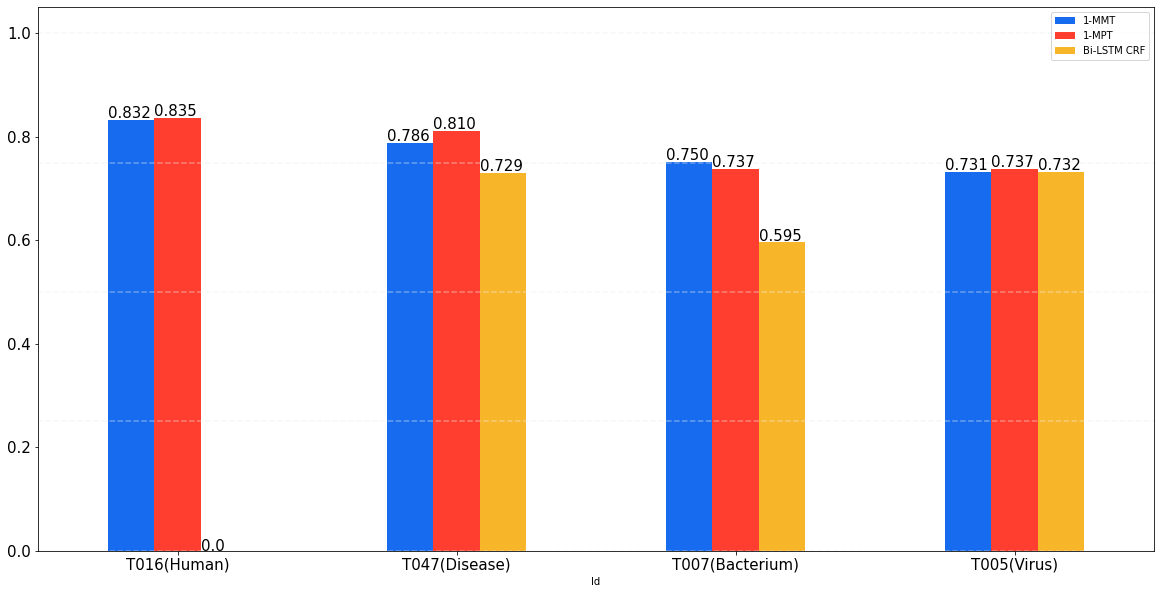

In [0]:
ax = df.set_index('Id')[['1-MMT', '1-MPT','Bi-LSTM CRF']].plot.bar(fontsize=15,color = ['#176BEF','#FF3E30','#F7B529'])

#vals = ax.get_yticks()
vals = [0.0,0.25,0.5,0.75,1.0]
for tick in vals:
  ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

#if horizontal bar graph is used
'''total = len(df['Id'])
for p in ax.patches:
        percentage = str(p.get_width())[0:4]
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2 - 0.035
        ax.text(x,y,percentage,fontsize=15)
'''

for p in ax.patches:
    ax.text(p.get_x() , p.get_height()*1.005 , str(p.get_height())[0:5] ,fontsize = 15)
plt.xticks(rotation=0)
ax.legend(loc = 1)
fig = plt.gcf()
fig.set_size_inches(20,10, forward=True)
fig.savefig('ppt_bar_graph.png',format='png', bbox_inches='tight', dpi=300)